# NCI60 Gene Expression Data Importation
**Local Version**: 1
**Source Version**: NA

This notebook will import raw NCI60 gene expresion data using the [Cell Miner R](http://bioconductor.statistik.tu-dortmund.de/packages/3.4/data/experiment/manuals/rcellminerData/man/rcellminerData.pdf) package.

In [1]:
%run -m ipy_startup
%run -m ipy_seaborn
%load_ext rpy2.ipython
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import na_utils
from py_utils import collection_utils as cu
from py_utils.collection_utils import subset

In [2]:
%%R 
# Load CellMiner package containing necessary data
library('rcellminerData')

In [3]:
%%R -o d
# Load NCI60 expression data
# Note that a similar alternative to molData@eSetList$exp is molData@eSetList$xai, indicated in the documentation as 
# "Expression (Avg. log2 Intensity).".  Given that the values for this alternative are always positive, the 
# assumption is being made here that that the "xai" value is a log2 concentration without comparison to a control 
# tissue sample which makes it less useful and less compatible with a typical expression value where the log2 value 
# is the ratio of the expression for the tumor sample over the control tissue sample.
d <- as.data.frame(molData@eSetList$exp)

In [4]:
d.index.name = 'CELL_LINE_ID'
d = d.reset_index()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 25723 entries, CELL_LINE_ID to ZZZ3
dtypes: float64(25722), object(1)
memory usage: 11.8+ MB


In [5]:
d.head()

,CELL_LINE_ID,X5.HT3C2,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
0,BR:MCF7,-0.27,1.36,-0.14,-0.38,-0.35,-0.11,0.31,1.99,0.28,...,0.58,1.23,0.60,0.36,0.78,0.06,-1.01,-1.81,0.39,-0.39
1,BR:MDA_MB_231,0.99,-0.15,-0.18,-0.40,-0.29,-0.13,0.65,0.41,0.08,...,1.25,0.17,0.70,-0.67,0.18,0.13,-0.48,0.03,-0.33,2.31
2,BR:HS578T,0.70,0.87,0.15,-0.24,-0.16,-0.13,1.20,-0.75,1.08,...,-1.73,-0.56,-0.77,-0.45,-0.80,-0.29,0.89,1.24,0.41,0.75
3,BR:BT_549,-0.42,1.70,-0.10,-0.39,-0.44,-0.12,0.03,0.19,0.74,...,-0.23,-0.07,-0.25,-0.59,1.03,-0.17,-0.45,0.32,0.83,0.56
4,BR:T47D,0.45,1.38,-0.16,-0.38,-0.51,-0.21,-0.66,-0.21,-0.47,...,0.83,1.01,0.75,0.68,0.89,-0.03,-0.39,-1.53,0.38,-1.13


In [6]:
na_utils.get_null_stats(d)

{'n': 1543380,
 'n_non_null': 1533160,
 'n_null': 10220,
 'pct_null': 0.66218300094597571}

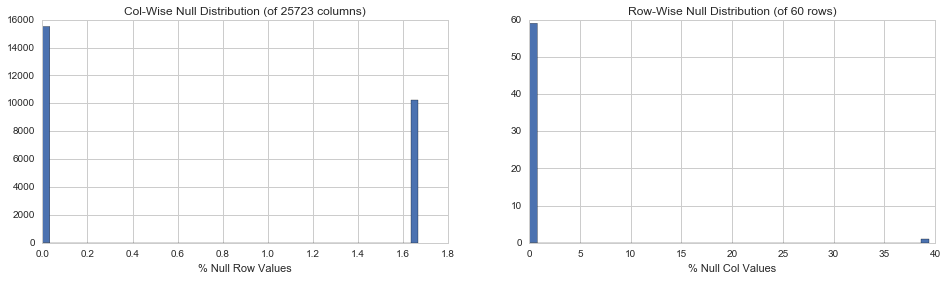

In [7]:
na_utils.plot_dim_null_frequencies(d)

In [8]:
d = pd.melt(d, id_vars='CELL_LINE_ID', var_name='GENE_ID', value_name='VALUE')
assert d.groupby(['CELL_LINE_ID', 'GENE_ID']).size().max() == 1
d = subset(d, lambda df: df[df['VALUE'].notnull()], subset_op='Remove null values for column "VALUE"')
d.head()

[Remove null values for column "VALUE"] Records before = 1543320, Records after = 1533100, Records removed = 10220 (%0.66)


,CELL_LINE_ID,GENE_ID,VALUE
0,BR:MCF7,X5.HT3C2,-0.27
1,BR:MDA_MB_231,X5.HT3C2,0.99
2,BR:HS578T,X5.HT3C2,0.70
3,BR:BT_549,X5.HT3C2,-0.42
4,BR:T47D,X5.HT3C2,0.45


In [9]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1533100 entries, 0 to 1543319
Data columns (total 3 columns):
CELL_LINE_ID    1533100 non-null object
GENE_ID         1533100 non-null object
VALUE           1533100 non-null float64
dtypes: float64(1), object(2)
memory usage: 46.8+ MB


In [22]:
#d_exp[d_exp['CELL_LINE_ID'].str.contains('HS578T')]

In [10]:
assert d['CELL_LINE_ID'].nunique() == 60, 'Did not find data for exactly 60 cell lines'
d['CELL_LINE_ID'].nunique()

60

In [11]:
assert np.all(pd.notnull(d)), 'Export data contains null values'
db.save(d, src.NCI60_v1, db.RAW, 'gene-expression')

'/Users/eczech/data/research/mgds/raw/nci60_v1_gene-expression.pkl'